In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [87]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import nibabel as nib
import pygalmesh
from mpi4py import MPI
import fenics as fe
import fenics_adjoint as fa
import torch
import torch.nn.functional as F
import torch_fenics
import tqdm
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('..')
import project

In [3]:
%autoreload
emory4dct = project.imaging.Emory4DCT('../data/Emory-4DCT')

In [4]:
examples = []
for case in emory4dct.cases:
    for fixed_phase in emory4dct.phases:
        moving_phase = (fixed_phase + 10) % 100
        
        anat_file = case.nifti_file(fixed_phase)
        disp_file = case.disp_file(moving_phase, fixed_phase)
        mask_file = case.mask_file(fixed_phase, roi='lung_combined_mask')
        mesh_file = case.mesh_file(fixed_phase, radius=20)
        
        example = (anat_file, disp_file, mask_file, mesh_file)
        examples.append(example)
        
len(examples)

100

In [5]:
class Dataset(torch.utils.data.Dataset):
     
    def __init__(self, examples, dtype=torch.float32, device='cuda'):
        super().__init__()

        self.examples = examples
        self.dtype = dtype
        self.device = device

        self.cache = [None] * len(examples)
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        if self.cache[idx] is None:
            self.cache[idx] = self.load_example(idx)
        return self.cache[idx]
    
    def load_example(self, idx):
        anat_file, disp_file, mask_file, mesh_file = self.examples[idx]    
        example_name = anat_file.stem
        
        # load images from NIFTI files
        anat = load_nii_file(anat_file)
        disp = load_nii_file(disp_file)
        mask = load_nii_file(mask_file)
        
        # load mesh from xdmf file
        mesh = load_mesh_file(mesh_file)

        # get image spatial resolution
        resolution = anat.header.get_zooms()

        # convert arrays to tensors with shape (c,x,y,z)
        anat = torch.as_tensor(anat.get_fdata(), dtype=self.dtype, device=self.device).unsqueeze(0)
        disp = torch.as_tensor(disp.get_fdata(), dtype=self.dtype, device=self.device).permute(3,0,1,2)
        mask = torch.as_tensor(mask.get_fdata(), dtype=self.dtype, device=self.device).unsqueeze(0)

        return anat, disp, mask, mesh, resolution, example_name
    
def load_nii_file(nii_file):
    print(f'Loading {nii_file}... ', end='')
    nifti = nib.load(nii_file)
    print(nifti.header.get_data_shape())
    return nifti

def load_mesh_file(mesh_file):
    print(f'Loading {mesh_file}... ', end='')
    mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, str(mesh_file)) as f:
        f.read(mesh)
    print(mesh.num_vertices())
    return mesh

def collate_fn(batch):
    # we need a custom collate_fn bc mesh is not a tensor
    anat = torch.stack([ex[0] for ex in batch])
    mask = torch.stack([ex[1] for ex in batch])
    disp = torch.stack([ex[2] for ex in batch])
    resolution = [ex[3] for ex in batch]
    mesh = [ex[4] for ex in batch]
    name = [ex[5] for ex in batch]
    return anat, mask, disp, resolution, mesh, name

dataset = Dataset(examples, dtype=torch.float32, device='cuda')
example = dataset[0]

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T10_T00.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T00_20.xdmf... 346


In [6]:
def my_tensor_repr(t):
    shape = tuple(t.shape)
    is_nan = t.float().isnan()
    not_nan = ~is_nan
    num_nan = is_nan.sum()
    mean = t[not_nan].mean()
    std = t[not_nan].std() if not_nan.sum() > 1 else np.nan # hide the torch warning
    return f'Tensor(shape={shape}, μ={mean:.4f}, σ={std:.4f}, #nan={num_nan}, dtype={t.dtype}, device={t.device})'

torch.Tensor.__repr__ = my_tensor_repr

example

(Tensor(shape=(1, 256, 256, 94), μ=-487.4489, σ=477.8683, #nan=0, dtype=torch.float32, device=cuda:0),
 Tensor(shape=(3, 256, 256, 94), μ=0.0061, σ=0.2449, #nan=0, dtype=torch.float32, device=cuda:0),
 Tensor(shape=(1, 256, 256, 94), μ=0.1570, σ=0.3638, #nan=0, dtype=torch.float32, device=cuda:0),
 (0.97, 0.97, 2.5),
 'case1_T00.nii')

In [69]:
class ConvUnit(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.norm = torch.nn.BatchNorm3d(in_channels)
        self.conv = torch.nn.Conv3d(in_channels, out_channels, kernel_size, padding='same', padding_mode='replicate')
        self.relu = torch.nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        x = self.norm(x)
        x = self.conv(x)
        x = self.relu(x)
        return x


class ConvBlock(torch.nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size, num_conv_layers, hidden_channels=None):
        super().__init__()
        
        if not hidden_channels:
            hidden_channels = out_channels
        elif num_conv_layers < 2:
            print('Warning: hidden_channels argument only used if num_conv_layers >= 2')

        for i in range(num_conv_layers):
            layer = ConvUnit(
                in_channels=(hidden_channels if i > 0 else in_channels),
                out_channels=(hidden_channels if i < num_conv_layers - 1 else out_channels),
                kernel_size=kernel_size
            )
            self.add_module(f'conv_unit{i}', layer)
            

class Upsample(torch.nn.Module):
    
    def __init__(self, mode):
        super().__init__()
        self.mode = mode
        
    def __repr__(self):
        return f'{type(self).__name__}(mode={self.mode})'
        
    def forward(self, x, size):
        return F.interpolate(x, size=size, mode=self.mode)


class EncoderBlock(torch.nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        conv_kernel_size,
        num_conv_layers,
        hidden_channels=None,
        apply_pooling=True,
        pool_kernel_size=2,
        pool_type='max'
    ):
        super().__init__()
        assert pool_type in {'max', 'avg'}

        if apply_pooling:
            if pool_type == 'max':
                self.pooling = torch.nn.MaxPool3d(kernel_size=pool_kernel_size)
            elif pool_type == 'avg':
                self.pooling = torch.nn.AvgPool3d(kernel_size=pool_kernel_size)
        else:
            self.pooling = None
            
        self.conv_block = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=conv_kernel_size,
            num_conv_layers=num_conv_layers,
            hidden_channels=hidden_channels
        )
        
    def forward(self, x):
        if self.pooling:
            x = self.pooling(x)
        x = self.conv_block(x)
        return x


class DecoderBlock(torch.nn.Module):
    
    def __init__(
        self,
        in_channels,
        out_channels,
        conv_kernel_size,
        num_conv_layers,
        hidden_channels=None,
        upsample_mode='nearest'
    ):
        super().__init__()

        self.upsample = Upsample(mode=upsample_mode)

        self.conv_block = ConvBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=conv_kernel_size,
            num_conv_layers=num_conv_layers,
            hidden_channels=hidden_channels,
        )

    def forward(self, x, encoder_feats):
        x = self.upsample(x, size=encoder_feats.shape[2:])
        x = torch.cat([x, encoder_feats], dim=1)
        x = self.conv_block(x)
        return x


In [70]:
class UNet3D(torch.nn.Module):
    
    def __init__(
        self,
        in_channels,
        out_channels,
        num_levels,
        num_conv_layers,
        conv_channels,
        conv_kernel_size,
        pool_kernel_size=2,
        pool_type='max',
        upsample_mode='trilinear',
    ):
        super().__init__()
        assert num_levels > 0
        
        curr_channels = in_channels
        next_channels = conv_channels
        
        self.encoder = torch.nn.Sequential()
        for i in range(num_levels):
        
            encoder_block = EncoderBlock(
                in_channels=curr_channels,
                out_channels=next_channels,
                conv_kernel_size=conv_kernel_size,
                num_conv_layers=num_conv_layers,
                apply_pooling=(i > 0),
                pool_kernel_size=pool_kernel_size,
                pool_type=pool_type
            )
            self.encoder.add_module(f'level{i}', encoder_block)

            curr_channels = next_channels
            next_channels = curr_channels * 2
        
        next_channels = curr_channels // 2
        
        self.decoder = torch.nn.Sequential()
        for i in reversed(range(num_levels - 1)):

            decoder_block = DecoderBlock(
                in_channels=curr_channels + next_channels,
                out_channels=next_channels,
                conv_kernel_size=conv_kernel_size,
                num_conv_layers=num_conv_layers,
                upsample_mode=upsample_mode
            )
            self.decoder.add_module(f'level{i}', decoder_block)
            
            curr_channels = next_channels
            next_channels = curr_channels // 2
        
        self.final_conv = torch.nn.Conv3d(curr_channels, out_channels, kernel_size=1)

    def forward(self, x):
        
        # encoder part
        encoder_feats = []
        for i, encoder in enumerate(self.encoder):
            x = encoder(x)
            encoder_feats.append(x)
        
        # reverse encoder features to align with decoder
        encoder_feats = encoder_feats[::-1]
    
        # decoder part
        for i, decoder in enumerate(self.decoder):
            x = decoder(x, encoder_feats[i+1])

        return self.final_conv(x)


model = UNet3D(in_channels=1, out_channels=1, num_levels=3, num_conv_layers=2, conv_channels=4, conv_kernel_size=3)
model.cuda()

UNet3D(
  (encoder): Sequential(
    (level0): EncoderBlock(
      (conv_block): ConvBlock(
        (conv_unit0): ConvUnit(
          (norm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (conv_unit1): ConvUnit(
          (norm): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (level1): EncoderBlock(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_block): ConvBlock(
        (conv_unit0): ConvUnit(
          (norm): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [89]:
class LinearElasticPDE(torch_fenics.FEniCSModule):
    
    def __init__(self, mesh):
        super().__init__()
        self.mesh = mesh
        self.S = fe.FunctionSpace(mesh, 'P', 1)
        self.V = fe.VectorFunctionSpace(mesh, 'P', 1)
        
    def __repr__(self):
        return f'{type(self).__name__}({self.mesh})'
        
    def input_templates(self):
        scalar_f = fa.Function(self.S)
        vector_f = fa.Function(self.V)
        return vector_f, scalar_f, scalar_f
    
    def solve(self, u_true, mu, rho):

        # define physical parameters
        g  = 9.8e-3 # gravitational acc (mm/s^2)
        nu = 0.4    # Poisson's ratio (unitless)

        # Lame's first parameter (Pa)
        lam = 2*mu*nu/(1 - 2*nu)

        # set displacement boundary condition
        u_bc = fa.DirichletBC(self.V, u_true, 'on_boundary')

        # body force and traction
        #b = fe.as_vector([0, rho*g, 0])
        b = fa.Constant([0, 0, 0])
        t = fa.Constant([0, 0, 0])

        # define stress and strain
        def epsilon(u):
            return (fe.grad(u) + fe.grad(u).T) / 2

        def sigma(u):
            I = fe.Identity(u.geometric_dimension())
            return lam*fe.div(u)*I + 2*mu*epsilon(u)

        # weak formulation
        u = fe.TrialFunction(self.V)
        v = fe.TestFunction(self.V)

        a = fe.inner(sigma(u), epsilon(v)) * fe.dx
        L = fe.dot(b, v)*fe.dx + fe.dot(t, v)*fe.dx

        u_pred = fa.Function(self.V)
        fa.solve(a == L, u_pred, u_bc)

        return u_pred


In [90]:
def as_xarray(a, dims=None, coords=None, name=None):
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()
    if dims is None:
        dims = [f'dim{i}' for i in range(a.ndim)]
    if coords is None:
        coords = {d: np.arange(a.shape[i]) for i, d in enumerate(dims)}
    return xr.DataArray(a, dims=dims, coords=coords, name=name)

#project.visual.view(as_xarray(output_image[0], dims=['component', 'x', 'y', 'z']), cmap='seismic')

case1_T00.nii
Tensor(shape=(1, 256, 256, 94), μ=-487.4489, σ=477.8683, #nan=0, dtype=torch.float32, device=cuda:0)


<IPython.core.display.Javascript object>


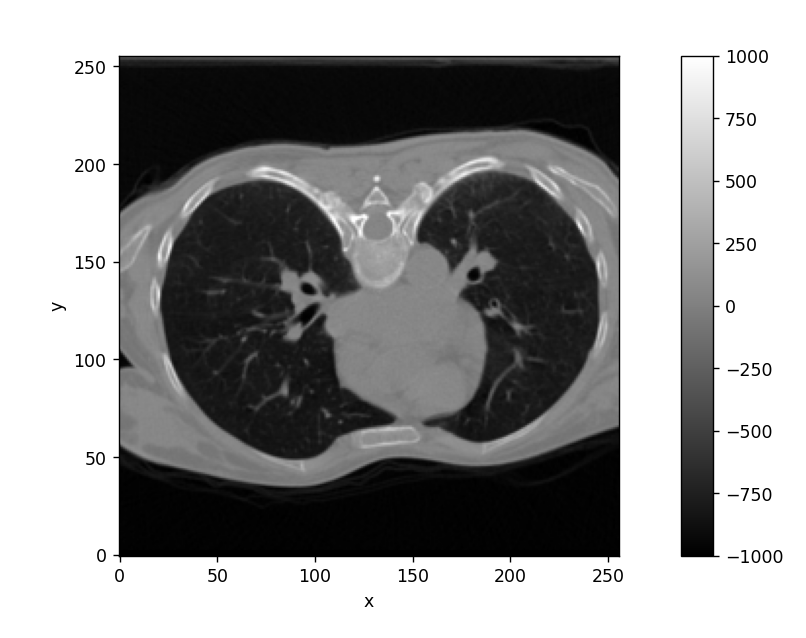

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [73]:
anat_image, u_true_image, mask, mesh, resolution, example_name = example
print(example_name)
print(anat_image)

project.visual.view(as_xarray(anat_image, dims=['channel', 'x', 'y', 'z'], name='CT')).update_index(channel=0, z=45)

Tensor(shape=(1, 256, 256, 94), μ=656.8214, σ=159.0883, #nan=0, dtype=torch.float32, device=cuda:0)


<IPython.core.display.Javascript object>


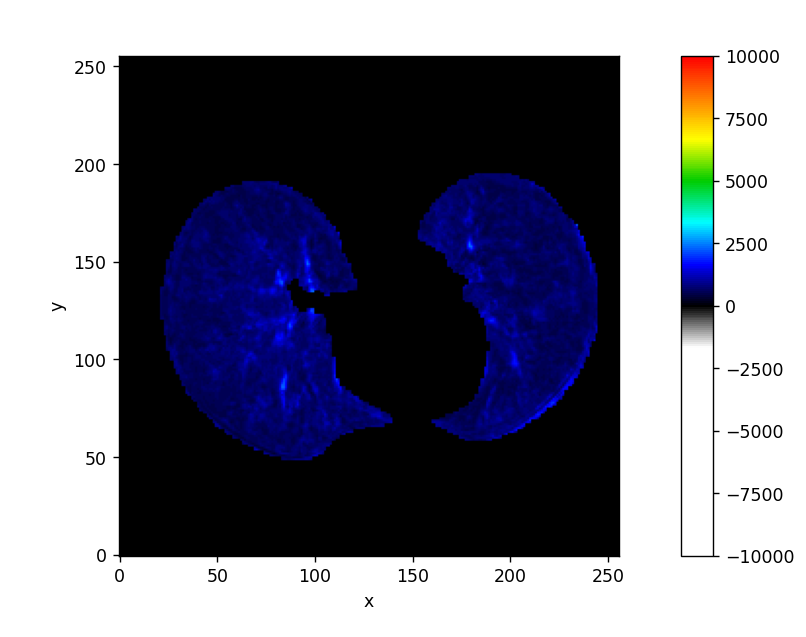

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [74]:
mu_pred_image = model.forward(anat_image.unsqueeze(0))[0]
mu_pred_image = torch.nn.functional.softplus(mu_pred_image) * 1000
print(mu_pred_image)

project.visual.view(as_xarray(mu_pred_image * mask, dims=['channel', 'x', 'y', 'z'], name='mu'), vmax=1e4).update_index(channel=0, z=45)

Tensor(shape=(1, 256, 256, 94), μ=512.5510, σ=477.8683, #nan=0, dtype=torch.float32, device=cuda:0)


<IPython.core.display.Javascript object>


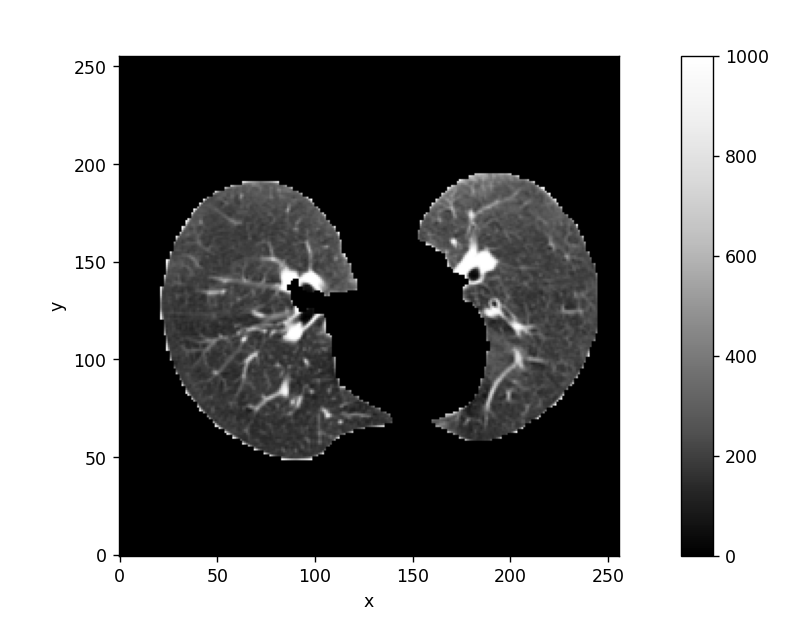

interactive(children=(SelectionSlider(description='channel', options=((0, 0),), value=0), SelectionSlider(desc…

In [75]:
rho_image = (1 + anat_image/1000) * 1000
print(rho_image)

project.visual.view(as_xarray(rho_image * mask, dims=['channel', 'x', 'y', 'z']), cmap='Greys_r', vmin=0, vmax=1000).update_index(channel=0, z=45)

<IPython.core.display.Javascript object>


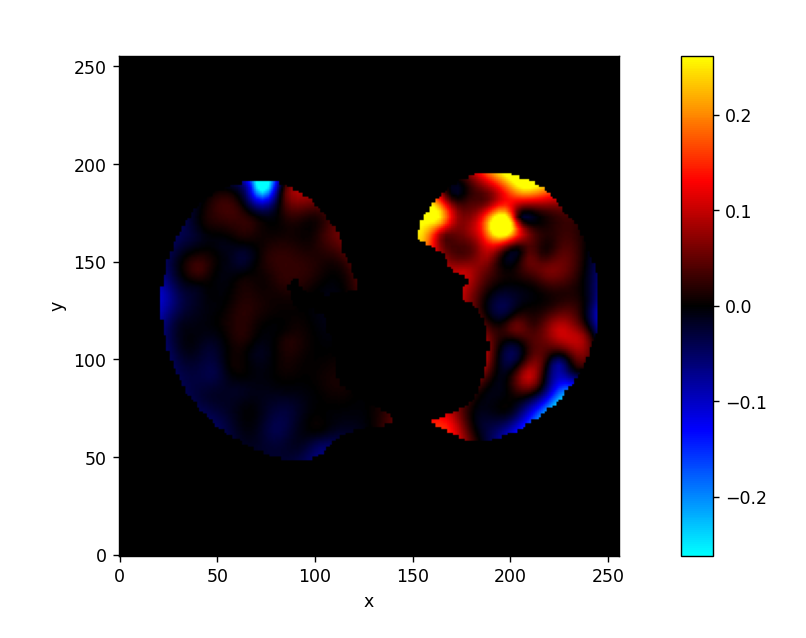

interactive(children=(SelectionSlider(description='channel', options=((0, 0), (1, 1), (2, 2)), value=0), Selec…

In [76]:
project.visual.view(as_xarray(u_true_image * mask, dims=['channel', 'x', 'y', 'z'])).update_index(channel=2, z=45)

In [79]:
pde = LinearElasticPDE(mesh)

In [80]:
u_true_dofs = project.interpolate.image_to_dofs(u_true_image, resolution, pde.V).cpu()
u_dofs

Tensor(shape=(346, 3), μ=0.0055, σ=0.1595, #nan=0, dtype=torch.float64, device=cpu)

In [81]:
mu_pred_dofs = project.interpolate.image_to_dofs(mu_pred_image, resolution, pde.S).cpu()
mu_pred_dofs

Tensor(shape=(346,), μ=819.5241, σ=254.5626, #nan=0, dtype=torch.float64, device=cpu)

In [82]:
rho_dofs = project.interpolate.image_to_dofs(rho_image, resolution, pde.S).cpu()
rho_dofs

Tensor(shape=(346,), μ=515.6650, σ=211.0198, #nan=0, dtype=torch.float64, device=cpu)

In [83]:
u_pred_dofs = pde.forward(
    u_true_dofs.unsqueeze(0),
    mu_pred_dofs.unsqueeze(0),
    rho_dofs.unsqueeze(0),
)[0]

u_pred_dofs

Tensor(shape=(346, 3), μ=0.0026, σ=0.1645, #nan=0, dtype=torch.float64, device=cpu)

In [84]:
%%time
u_pred_image = project.interpolate.dofs_to_image(u_pred_dofs, pde.V, u_true_image.shape[-3:], resolution)
u_pred_image

CPU times: user 1min 8s, sys: 56.6 ms, total: 1min 8s
Wall time: 1min 8s


array([[[[ 1.28486447e-01,  4.06130187e-01, -3.74378511e-01],
         [ 1.32931216e-01,  4.13598636e-01, -3.62560696e-01],
         [-1.47912527e-03,  4.21685449e-01, -3.57668199e-01],
         ...,
         [ 1.43470409e+00, -1.23767290e-01, -1.18216074e-03],
         [ 1.45143700e+00, -1.28890894e-01, -7.77382917e-04],
         [ 1.63810570e+00,  5.77649581e-01,  4.54927039e-01]],

        [[ 1.25170367e-01,  3.99886729e-01, -3.73313205e-01],
         [ 1.29615136e-01,  4.07355178e-01, -3.61495390e-01],
         [ 1.34059906e-01,  4.14823628e-01, -3.49677575e-01],
         ...,
         [ 1.43119373e+00, -1.23904551e-01, -1.17875011e-03],
         [ 1.44792664e+00, -1.29028155e-01, -7.73972289e-04],
         [ 1.63056349e+00,  5.74642938e-01,  4.52128807e-01]],

        [[ 1.21854287e-01,  3.93643271e-01, -3.72247899e-01],
         [ 1.26299056e-01,  4.01111720e-01, -3.60430084e-01],
         [ 1.30743826e-01,  4.08580169e-01, -3.48612270e-01],
         ...,
         [ 8.80509890e-0

<IPython.core.display.Javascript object>


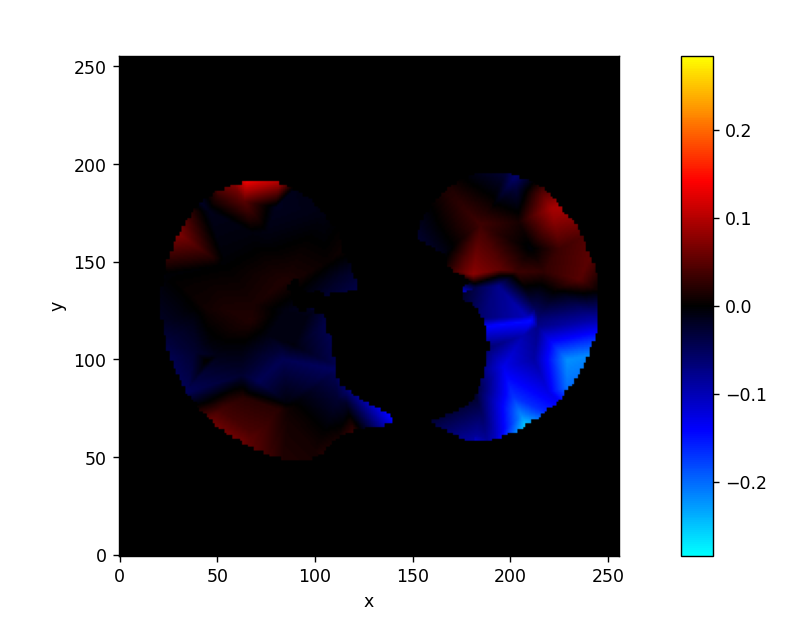

interactive(children=(SelectionSlider(description='z', options=((0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)…

In [85]:
project.visual.view(as_xarray(u_pred_image * mask.permute(1,2,3,0).detach().cpu().numpy(), dims=['x', 'y', 'z', 'c'])).update_index(c=0, z=45)

In [103]:
def compute_norm(u):
    u_norm2 = (u**2).sum(dim=-1)
    return torch.mean(u_norm2)

def compute_loss(u_pred, u_true, eps=1e-8):
    u_diff = (u_pred - u_true)
    u_diff_norm2 = (u_diff**2).sum(dim=-1)
    u_true_norm2 = (u_true**2).sum(dim=-1) + eps
    return torch.mean(u_diff_norm2 / u_true_norm2)

compute_loss(u_pred_dofs, u_true_dofs)

Tensor(shape=(), μ=3.8835, σ=nan, #nan=0, dtype=torch.float64, device=cpu)

In [144]:
class Trainer(object):
    
    def __init__(self, model, dataset, batch_size, learning_rate):
        self._model = model
        self.train_loader = torch.utils.data.DataLoader(
            dataset, batch_size, shuffle=True, collate_fn=collate_fn
        )
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.epoch = 0
        
        index_cols = ['epoch', 'batch', 'example', 'phase']
        self.metrics = pd.DataFrame(columns=index_cols)
        self.metrics.set_index(index_cols, inplace=True)
        
    @property
    def model(self):
        return self._model
    
    @property
    def dataset(self):
        return self.train_loader.dataset
        
    @property
    def batch_size(self):
        return self.train_loader.batch_sampler.batch_size
    
    @property
    def learning_rate(self):
        return self.optimizer.param_groups[0]['lr']
    
    def __repr__(self):
        if self.epoch > 0:
            loss = self.metrics.loc[self.epoch, 'loss'].mean()
        else:
            loss = None
        return f'{type(self).__name__}(epoch={self.epoch}, loss={loss})'
        
    def train(self, num_epochs):
        
        start_epoch = self.epoch
        stop_epoch = self.epoch + num_epochs

        print('Training...')
        for i in range(start_epoch, stop_epoch):
            print(f'Epoch {i+1}/{stop_epoch}')
            
            for j, batch in enumerate(self.train_loader):
                anat_image, u_true_image, mask, mesh, resolution, example_name = batch

                # predict elasticity from anatomical image
                mu_pred_image = self.model.forward(anat_image)
                mu_pred_image = torch.nn.functional.softplus(mu_pred_image) * 1000
                rho_image = (1 + anat_image/1000) * 1000

                # physical FEM simulation
                loss = 0
                for k in range(self.batch_size):          
                    pde = LinearElasticPDE(mesh[k])

                    # convert tensors to FEM basis coefficients
                    u_true_dofs = project.interpolate.image_to_dofs(u_true_image[k], resolution[k], pde.V).cpu()
                    mu_pred_dofs = project.interpolate.image_to_dofs(mu_pred_image[k], resolution[k], pde.S).cpu()
                    rho_dofs = project.interpolate.image_to_dofs(rho_image[k], resolution[k], pde.S).cpu()
    
                    # solve FEM for simulated displacement coefficients
                    u_pred_dofs = pde.forward(
                        u_true_dofs.unsqueeze(0),
                        mu_pred_dofs.unsqueeze(0),
                        rho_dofs.unsqueeze(0),
                    )[0]
    
                    # compare to true displacement coefficients
                    loss_k = compute_loss(u_pred_dofs, u_true_dofs)
                    loss += loss_k
                
                    # compute additional metrics
                    key = (i+1, j+1, example_name[k], 'train')
                    self.metrics.loc[key, 'loss'] = loss_k.item()
                    self.metrics.loc[key, 'mu_pred_norm'] = compute_norm(mu_pred_dofs).item()
                    self.metrics.loc[key, 'u_pred_norm'] = compute_norm(u_pred_dofs).item()
                    self.metrics.loc[key, 'u_true_norm'] = compute_norm(u_true_dofs).item()
            
                loss /= self.batch_size
                print(f'{example_name} loss = {loss:.4f}')
                
                loss.backward()
                self.optimizer.step()
            
            self.epoch += 1
    
    def test(self, example):
        anat_image, u_true_image, mask, mesh, resolution, example_name = example
        
        # predict elasticity from anatomical image
        mu_pred_image = self.model.forward(anat_image.unsqueeze(0))[0]
        mu_pred_image = torch.nn.functional.softplus(mu_pred_image) * 1000
        rho_image = (1 + anat_image/1000) * 1000
        
        # physical FEM simulation
        pde = LinearElasticPDE(mesh)
        
        # convert tensors to FEM basis coefficients
        u_true_dofs = project.interpolate.image_to_dofs(u_true_image, resolution, pde.V).cpu()
        mu_pred_dofs = project.interpolate.image_to_dofs(mu_pred_image, resolution, pde.S).cpu()
        rho_dofs = project.interpolate.image_to_dofs(rho_image, resolution, pde.S).cpu()

        # solve FEM for simulated displacement coefficients
        u_pred_dofs = pde.forward(
            u_true_dofs.unsqueeze(0),
            mu_pred_dofs.unsqueeze(0),
            rho_dofs.unsqueeze(0),
        )[0]

        # compare to true displacement coefficients
        loss = compute_loss(u_pred_dofs, u_true_dofs)
        
        # convert simulated displacement field to image domain      
        u_pred_image = project.interpolate.dofs_to_image(u_pred_dofs, pde.V, u_true_image.shape[-3:], resolution)
        u_pred_image = torch.as_tensor(u_pred_image).permute(3,0,1,2)
        
        return mu_pred_image, u_pred_image

trainer = Trainer(model, dataset, batch_size=4, learning_rate=1e-5)
trainer

Trainer(epoch=0, loss=None)

In [145]:
%%time
trainer.train(100)

Training...
Epoch 1/100
['case10_T20.nii', 'case6_T60.nii', 'case7_T60.nii', 'case3_T50.nii'] loss = 0.2037
['case7_T00.nii', 'case4_T30.nii', 'case1_T00.nii', 'case3_T20.nii'] loss = 0.2731
['case9_T40.nii', 'case10_T60.nii', 'case6_T30.nii', 'case9_T30.nii'] loss = 0.1998
['case7_T50.nii', 'case1_T50.nii', 'case1_T90.nii', 'case4_T40.nii'] loss = 0.2379
['case1_T20.nii', 'case8_T60.nii', 'case6_T40.nii', 'case9_T60.nii'] loss = 0.1666
['case5_T80.nii', 'case7_T20.nii', 'case5_T40.nii', 'case1_T70.nii'] loss = 0.3154
['case7_T70.nii', 'case8_T70.nii', 'case4_T60.nii', 'case8_T20.nii'] loss = 0.1896
['case6_T80.nii', 'case6_T20.nii', 'case5_T50.nii', 'case8_T00.nii'] loss = 0.2512
['case2_T70.nii', 'case5_T00.nii', 'case10_T90.nii', 'case6_T90.nii'] loss = 0.2226
['case6_T50.nii', 'case3_T30.nii', 'case5_T20.nii', 'case4_T00.nii'] loss = 0.1900
['case8_T30.nii', 'case8_T90.nii', 'case7_T40.nii', 'case2_T00.nii'] loss = 0.2354
['case1_T60.nii', 'case10_T30.nii', 'case4_T10.nii', 'case10

['case5_T40.nii', 'case7_T40.nii', 'case10_T80.nii', 'case7_T60.nii'] loss = 0.2187
['case8_T60.nii', 'case2_T30.nii', 'case5_T20.nii', 'case7_T10.nii'] loss = 0.2942
Epoch 5/100
['case9_T00.nii', 'case5_T80.nii', 'case8_T80.nii', 'case9_T40.nii'] loss = 0.2373
['case3_T50.nii', 'case3_T60.nii', 'case6_T70.nii', 'case7_T60.nii'] loss = 0.2314
['case1_T90.nii', 'case2_T10.nii', 'case2_T70.nii', 'case8_T00.nii'] loss = 0.3387
['case8_T10.nii', 'case10_T30.nii', 'case5_T00.nii', 'case6_T20.nii'] loss = 0.1865
['case10_T00.nii', 'case7_T50.nii', 'case3_T20.nii', 'case4_T10.nii'] loss = 0.1771
['case7_T70.nii', 'case6_T00.nii', 'case9_T60.nii', 'case3_T40.nii'] loss = 0.1731
['case5_T10.nii', 'case5_T90.nii', 'case10_T80.nii', 'case10_T60.nii'] loss = 0.1840
['case6_T80.nii', 'case9_T50.nii', 'case10_T70.nii', 'case8_T90.nii'] loss = 0.1827
['case8_T60.nii', 'case1_T80.nii', 'case8_T30.nii', 'case8_T40.nii'] loss = 0.2320
['case7_T40.nii', 'case2_T00.nii', 'case9_T10.nii', 'case2_T80.nii'] 

['case4_T20.nii', 'case1_T70.nii', 'case3_T50.nii', 'case9_T20.nii'] loss = 0.2563
['case10_T10.nii', 'case5_T20.nii', 'case9_T50.nii', 'case6_T60.nii'] loss = 0.1637
['case4_T50.nii', 'case3_T70.nii', 'case4_T40.nii', 'case5_T30.nii'] loss = 0.2446
['case1_T30.nii', 'case10_T30.nii', 'case2_T80.nii', 'case6_T90.nii'] loss = 0.2250
Epoch 9/100
['case5_T20.nii', 'case2_T80.nii', 'case10_T10.nii', 'case10_T40.nii'] loss = 0.2596
['case1_T30.nii', 'case8_T50.nii', 'case4_T60.nii', 'case7_T80.nii'] loss = 0.2394
['case4_T00.nii', 'case6_T30.nii', 'case9_T30.nii', 'case6_T00.nii'] loss = 0.1576
['case5_T50.nii', 'case3_T10.nii', 'case8_T10.nii', 'case9_T20.nii'] loss = 0.1563
['case4_T70.nii', 'case3_T50.nii', 'case2_T70.nii', 'case7_T50.nii'] loss = 0.2628
['case9_T70.nii', 'case7_T20.nii', 'case7_T30.nii', 'case1_T50.nii'] loss = 0.2448
['case6_T60.nii', 'case1_T40.nii', 'case3_T00.nii', 'case9_T00.nii'] loss = 0.1768
['case4_T30.nii', 'case5_T40.nii', 'case10_T20.nii', 'case10_T30.nii'] 

['case4_T70.nii', 'case5_T90.nii', 'case2_T30.nii', 'case9_T40.nii'] loss = 0.3374
['case7_T50.nii', 'case8_T80.nii', 'case10_T60.nii', 'case10_T30.nii'] loss = 0.1506
['case1_T70.nii', 'case9_T50.nii', 'case8_T90.nii', 'case7_T00.nii'] loss = 0.2225
['case3_T20.nii', 'case5_T40.nii', 'case4_T10.nii', 'case4_T60.nii'] loss = 0.3194
['case9_T00.nii', 'case9_T90.nii', 'case4_T90.nii', 'case1_T20.nii'] loss = 0.1604
['case10_T70.nii', 'case10_T40.nii', 'case6_T00.nii', 'case10_T10.nii'] loss = 0.2139
Epoch 13/100
['case9_T60.nii', 'case8_T20.nii', 'case6_T40.nii', 'case8_T10.nii'] loss = 0.1527
['case10_T40.nii', 'case9_T20.nii', 'case7_T20.nii', 'case2_T20.nii'] loss = 0.1840
['case5_T20.nii', 'case1_T40.nii', 'case4_T50.nii', 'case3_T20.nii'] loss = 0.2484
['case10_T30.nii', 'case3_T50.nii', 'case1_T20.nii', 'case10_T60.nii'] loss = 0.1915
['case7_T50.nii', 'case4_T10.nii', 'case4_T30.nii', 'case2_T70.nii'] loss = 0.2438
['case6_T30.nii', 'case5_T90.nii', 'case2_T00.nii', 'case5_T50.nii

['case2_T60.nii', 'case10_T70.nii', 'case2_T40.nii', 'case9_T20.nii'] loss = 0.2687
['case3_T30.nii', 'case9_T00.nii', 'case2_T70.nii', 'case6_T00.nii'] loss = 0.2300
['case8_T20.nii', 'case6_T60.nii', 'case5_T40.nii', 'case4_T40.nii'] loss = 0.2333
['case7_T70.nii', 'case8_T40.nii', 'case10_T20.nii', 'case8_T80.nii'] loss = 0.1328
['case2_T80.nii', 'case10_T50.nii', 'case9_T10.nii', 'case8_T30.nii'] loss = 0.1821
['case6_T70.nii', 'case3_T40.nii', 'case9_T60.nii', 'case2_T00.nii'] loss = 0.1611
['case9_T30.nii', 'case1_T90.nii', 'case5_T90.nii', 'case3_T50.nii'] loss = 0.2735
['case1_T50.nii', 'case5_T00.nii', 'case4_T60.nii', 'case7_T50.nii'] loss = 0.2703
Epoch 17/100
['case6_T90.nii', 'case2_T50.nii', 'case3_T10.nii', 'case7_T30.nii'] loss = 0.2834
['case6_T40.nii', 'case1_T90.nii', 'case1_T30.nii', 'case10_T30.nii'] loss = 0.2159
['case10_T20.nii', 'case6_T50.nii', 'case10_T70.nii', 'case9_T30.nii'] loss = 0.1531
['case5_T00.nii', 'case2_T80.nii', 'case9_T70.nii', 'case5_T40.nii']

['case4_T10.nii', 'case2_T50.nii', 'case6_T30.nii', 'case2_T10.nii'] loss = 0.2484
['case1_T30.nii', 'case6_T50.nii', 'case5_T60.nii', 'case9_T50.nii'] loss = 0.1617
['case1_T70.nii', 'case5_T20.nii', 'case10_T50.nii', 'case8_T80.nii'] loss = 0.1884
['case10_T10.nii', 'case10_T00.nii', 'case6_T10.nii', 'case8_T20.nii'] loss = 0.1684
['case10_T80.nii', 'case5_T90.nii', 'case4_T20.nii', 'case1_T20.nii'] loss = 0.2255
['case2_T00.nii', 'case8_T10.nii', 'case2_T90.nii', 'case4_T30.nii'] loss = 0.2758
['case9_T30.nii', 'case7_T50.nii', 'case4_T60.nii', 'case4_T80.nii'] loss = 0.2062
['case1_T60.nii', 'case7_T00.nii', 'case3_T90.nii', 'case2_T80.nii'] loss = 0.2856
['case1_T90.nii', 'case3_T80.nii', 'case8_T30.nii', 'case10_T90.nii'] loss = 0.1788
['case8_T00.nii', 'case2_T20.nii', 'case6_T60.nii', 'case9_T40.nii'] loss = 0.2997
Epoch 21/100
['case3_T50.nii', 'case6_T00.nii', 'case8_T10.nii', 'case9_T10.nii'] loss = 0.2133
['case10_T90.nii', 'case10_T00.nii', 'case1_T80.nii', 'case9_T40.nii'

['case6_T40.nii', 'case1_T60.nii', 'case9_T50.nii', 'case9_T30.nii'] loss = 0.1618
['case8_T70.nii', 'case5_T40.nii', 'case7_T40.nii', 'case6_T10.nii'] loss = 0.1943
['case10_T80.nii', 'case5_T10.nii', 'case2_T40.nii', 'case3_T00.nii'] loss = 0.2444
['case3_T40.nii', 'case1_T80.nii', 'case8_T80.nii', 'case8_T40.nii'] loss = 0.1871
['case7_T10.nii', 'case1_T90.nii', 'case10_T60.nii', 'case3_T80.nii'] loss = 0.1724
['case8_T10.nii', 'case6_T90.nii', 'case8_T50.nii', 'case5_T00.nii'] loss = 0.1777
['case8_T30.nii', 'case10_T90.nii', 'case3_T70.nii', 'case4_T10.nii'] loss = 0.1800
['case5_T30.nii', 'case3_T90.nii', 'case10_T40.nii', 'case2_T10.nii'] loss = 0.2445
['case10_T30.nii', 'case7_T30.nii', 'case4_T30.nii', 'case9_T70.nii'] loss = 0.2029
['case8_T60.nii', 'case4_T90.nii', 'case6_T30.nii', 'case9_T90.nii'] loss = 0.1786
['case5_T50.nii', 'case4_T70.nii', 'case10_T00.nii', 'case5_T60.nii'] loss = 0.1624
['case9_T60.nii', 'case5_T70.nii', 'case1_T20.nii', 'case1_T30.nii'] loss = 0.181

['case10_T80.nii', 'case8_T60.nii', 'case1_T20.nii', 'case1_T10.nii'] loss = 0.1982
['case2_T30.nii', 'case3_T90.nii', 'case3_T30.nii', 'case3_T10.nii'] loss = 0.3034
['case8_T00.nii', 'case1_T70.nii', 'case4_T60.nii', 'case7_T00.nii'] loss = 0.3105
['case10_T60.nii', 'case6_T40.nii', 'case3_T40.nii', 'case9_T90.nii'] loss = 0.1859
['case2_T50.nii', 'case6_T50.nii', 'case1_T90.nii', 'case2_T60.nii'] loss = 0.3052
['case6_T90.nii', 'case3_T70.nii', 'case9_T30.nii', 'case4_T90.nii'] loss = 0.1649
['case7_T50.nii', 'case9_T10.nii', 'case10_T40.nii', 'case7_T70.nii'] loss = 0.1403
['case3_T00.nii', 'case9_T60.nii', 'case1_T80.nii', 'case5_T50.nii'] loss = 0.1797
['case6_T60.nii', 'case7_T80.nii', 'case3_T50.nii', 'case1_T00.nii'] loss = 0.2854
['case9_T20.nii', 'case5_T80.nii', 'case1_T60.nii', 'case6_T80.nii'] loss = 0.1837
['case1_T30.nii', 'case7_T30.nii', 'case6_T70.nii', 'case9_T50.nii'] loss = 0.2037
['case10_T20.nii', 'case10_T30.nii', 'case8_T80.nii', 'case4_T10.nii'] loss = 0.1364

['case2_T30.nii', 'case2_T80.nii', 'case8_T70.nii', 'case10_T30.nii'] loss = 0.2658
['case4_T60.nii', 'case6_T50.nii', 'case1_T10.nii', 'case5_T90.nii'] loss = 0.2898
['case2_T70.nii', 'case5_T20.nii', 'case2_T50.nii', 'case7_T60.nii'] loss = 0.3278
['case9_T00.nii', 'case6_T00.nii', 'case6_T70.nii', 'case10_T80.nii'] loss = 0.1608
['case3_T80.nii', 'case3_T90.nii', 'case4_T70.nii', 'case8_T50.nii'] loss = 0.1902
['case4_T20.nii', 'case8_T10.nii', 'case5_T10.nii', 'case5_T40.nii'] loss = 0.2506
['case7_T10.nii', 'case9_T10.nii', 'case9_T90.nii', 'case5_T50.nii'] loss = 0.1804
['case7_T70.nii', 'case5_T80.nii', 'case1_T80.nii', 'case2_T20.nii'] loss = 0.2171
['case1_T50.nii', 'case1_T60.nii', 'case4_T80.nii', 'case9_T60.nii'] loss = 0.1527
['case3_T50.nii', 'case6_T20.nii', 'case7_T30.nii', 'case8_T80.nii'] loss = 0.2457
['case7_T00.nii', 'case8_T40.nii', 'case5_T70.nii', 'case10_T90.nii'] loss = 0.1586
['case6_T90.nii', 'case6_T30.nii', 'case4_T50.nii', 'case5_T00.nii'] loss = 0.1873
[

['case7_T00.nii', 'case8_T00.nii', 'case2_T90.nii', 'case3_T80.nii'] loss = 0.3385
['case10_T00.nii', 'case7_T70.nii', 'case2_T10.nii', 'case6_T80.nii'] loss = 0.1264
['case10_T10.nii', 'case3_T30.nii', 'case4_T40.nii', 'case5_T80.nii'] loss = 0.2196
['case1_T90.nii', 'case10_T30.nii', 'case10_T60.nii', 'case8_T80.nii'] loss = 0.1554
['case7_T30.nii', 'case4_T50.nii', 'case9_T30.nii', 'case4_T80.nii'] loss = 0.1837
['case6_T00.nii', 'case2_T50.nii', 'case4_T90.nii', 'case9_T40.nii'] loss = 0.3323
['case8_T20.nii', 'case10_T20.nii', 'case10_T80.nii', 'case7_T60.nii'] loss = 0.1580
['case1_T30.nii', 'case1_T10.nii', 'case3_T90.nii', 'case5_T30.nii'] loss = 0.3165
['case5_T40.nii', 'case5_T70.nii', 'case4_T70.nii', 'case8_T50.nii'] loss = 0.2290
['case4_T00.nii', 'case7_T10.nii', 'case4_T60.nii', 'case9_T10.nii'] loss = 0.1649
['case9_T50.nii', 'case6_T40.nii', 'case9_T20.nii', 'case10_T70.nii'] loss = 0.1393
['case6_T70.nii', 'case2_T40.nii', 'case8_T70.nii', 'case9_T00.nii'] loss = 0.22

['case2_T10.nii', 'case1_T00.nii', 'case2_T40.nii', 'case6_T10.nii'] loss = 0.3431
['case8_T70.nii', 'case3_T10.nii', 'case4_T60.nii', 'case8_T00.nii'] loss = 0.2737
['case10_T80.nii', 'case5_T60.nii', 'case3_T90.nii', 'case7_T70.nii'] loss = 0.1738
['case8_T60.nii', 'case4_T70.nii', 'case9_T50.nii', 'case3_T40.nii'] loss = 0.1650
['case1_T60.nii', 'case9_T40.nii', 'case2_T60.nii', 'case9_T90.nii'] loss = 0.2779
['case6_T30.nii', 'case6_T90.nii', 'case9_T60.nii', 'case6_T50.nii'] loss = 0.1248
['case9_T70.nii', 'case6_T20.nii', 'case7_T10.nii', 'case1_T80.nii'] loss = 0.2007
['case1_T20.nii', 'case5_T90.nii', 'case6_T40.nii', 'case7_T80.nii'] loss = 0.2248
['case5_T30.nii', 'case4_T00.nii', 'case10_T10.nii', 'case9_T80.nii'] loss = 0.1710
['case2_T30.nii', 'case4_T80.nii', 'case1_T40.nii', 'case9_T20.nii'] loss = 0.2368
['case7_T20.nii', 'case8_T80.nii', 'case10_T90.nii', 'case8_T50.nii'] loss = 0.1645
['case9_T00.nii', 'case1_T70.nii', 'case6_T80.nii', 'case6_T60.nii'] loss = 0.1377
[

['case1_T60.nii', 'case1_T90.nii', 'case4_T50.nii', 'case1_T00.nii'] loss = 0.2993
['case1_T40.nii', 'case7_T40.nii', 'case6_T50.nii', 'case9_T70.nii'] loss = 0.1896
['case8_T50.nii', 'case5_T50.nii', 'case4_T10.nii', 'case2_T10.nii'] loss = 0.1834
['case2_T50.nii', 'case3_T50.nii', 'case8_T10.nii', 'case5_T20.nii'] loss = 0.3119
['case5_T90.nii', 'case4_T90.nii', 'case10_T10.nii', 'case7_T60.nii'] loss = 0.2326
['case6_T60.nii', 'case5_T60.nii', 'case9_T40.nii', 'case3_T40.nii'] loss = 0.2181
['case5_T40.nii', 'case8_T40.nii', 'case8_T90.nii', 'case8_T70.nii'] loss = 0.2530
['case9_T10.nii', 'case9_T80.nii', 'case10_T80.nii', 'case10_T60.nii'] loss = 0.0956
['case6_T10.nii', 'case6_T40.nii', 'case2_T00.nii', 'case7_T50.nii'] loss = 0.1851
['case5_T70.nii', 'case8_T30.nii', 'case7_T00.nii', 'case2_T40.nii'] loss = 0.2568
['case4_T30.nii', 'case9_T50.nii', 'case3_T10.nii', 'case3_T80.nii'] loss = 0.1348
['case3_T70.nii', 'case2_T60.nii', 'case3_T30.nii', 'case6_T90.nii'] loss = 0.2036
[

['case9_T40.nii', 'case1_T50.nii', 'case10_T60.nii', 'case4_T80.nii'] loss = 0.1974
['case7_T70.nii', 'case3_T50.nii', 'case3_T00.nii', 'case1_T40.nii'] loss = 0.2427
['case4_T50.nii', 'case6_T20.nii', 'case8_T60.nii', 'case2_T40.nii'] loss = 0.2762
['case9_T20.nii', 'case10_T40.nii', 'case3_T40.nii', 'case7_T00.nii'] loss = 0.1622
['case3_T60.nii', 'case7_T90.nii', 'case2_T50.nii', 'case9_T10.nii'] loss = 0.2355
['case8_T70.nii', 'case1_T70.nii', 'case1_T30.nii', 'case8_T40.nii'] loss = 0.2031
['case4_T20.nii', 'case1_T20.nii', 'case6_T00.nii', 'case8_T80.nii'] loss = 0.2063
['case4_T70.nii', 'case9_T70.nii', 'case10_T00.nii', 'case10_T30.nii'] loss = 0.1418
['case6_T70.nii', 'case4_T90.nii', 'case4_T00.nii', 'case4_T30.nii'] loss = 0.1759
['case3_T90.nii', 'case9_T30.nii', 'case10_T10.nii', 'case5_T30.nii'] loss = 0.2396
['case7_T50.nii', 'case5_T60.nii', 'case7_T10.nii', 'case8_T10.nii'] loss = 0.1857
['case4_T40.nii', 'case1_T90.nii', 'case7_T20.nii', 'case8_T00.nii'] loss = 0.2719

['case9_T90.nii', 'case3_T00.nii', 'case8_T00.nii', 'case7_T00.nii'] loss = 0.2462
Epoch 52/100
['case1_T80.nii', 'case2_T60.nii', 'case7_T10.nii', 'case5_T80.nii'] loss = 0.2385
['case9_T60.nii', 'case3_T10.nii', 'case9_T50.nii', 'case6_T20.nii'] loss = 0.1240
['case2_T00.nii', 'case3_T00.nii', 'case3_T70.nii', 'case2_T90.nii'] loss = 0.2977
['case3_T80.nii', 'case8_T30.nii', 'case7_T00.nii', 'case9_T40.nii'] loss = 0.2101
['case7_T40.nii', 'case5_T90.nii', 'case1_T10.nii', 'case9_T70.nii'] loss = 0.2322
['case6_T00.nii', 'case9_T10.nii', 'case5_T20.nii', 'case2_T70.nii'] loss = 0.2265
['case10_T70.nii', 'case2_T20.nii', 'case6_T10.nii', 'case10_T20.nii'] loss = 0.1826
['case10_T30.nii', 'case2_T10.nii', 'case7_T50.nii', 'case1_T00.nii'] loss = 0.2615
['case2_T30.nii', 'case10_T80.nii', 'case9_T20.nii', 'case6_T90.nii'] loss = 0.1994
['case4_T20.nii', 'case8_T90.nii', 'case9_T80.nii', 'case1_T20.nii'] loss = 0.2287
['case5_T50.nii', 'case6_T80.nii', 'case1_T50.nii', 'case2_T40.nii'] l

['case1_T30.nii', 'case7_T20.nii', 'case1_T50.nii', 'case10_T60.nii'] loss = 0.2071
['case7_T60.nii', 'case1_T70.nii', 'case9_T80.nii', 'case2_T90.nii'] loss = 0.3087
['case10_T90.nii', 'case4_T70.nii', 'case3_T30.nii', 'case9_T90.nii'] loss = 0.1747
Epoch 56/100
['case8_T00.nii', 'case5_T00.nii', 'case8_T70.nii', 'case3_T20.nii'] loss = 0.2482
['case2_T00.nii', 'case7_T40.nii', 'case4_T00.nii', 'case1_T50.nii'] loss = 0.1495
['case3_T00.nii', 'case7_T60.nii', 'case10_T90.nii', 'case4_T40.nii'] loss = 0.1744
['case2_T30.nii', 'case6_T70.nii', 'case8_T90.nii', 'case8_T50.nii'] loss = 0.2790
['case5_T60.nii', 'case6_T10.nii', 'case5_T10.nii', 'case3_T30.nii'] loss = 0.1820
['case10_T60.nii', 'case9_T80.nii', 'case6_T80.nii', 'case4_T70.nii'] loss = 0.1113
['case3_T90.nii', 'case7_T20.nii', 'case2_T80.nii', 'case9_T90.nii'] loss = 0.2848
['case7_T10.nii', 'case7_T90.nii', 'case4_T20.nii', 'case3_T10.nii'] loss = 0.1973
['case6_T20.nii', 'case2_T50.nii', 'case2_T10.nii', 'case3_T70.nii'] l

['case7_T50.nii', 'case2_T50.nii', 'case2_T60.nii', 'case8_T90.nii'] loss = 0.3349
['case5_T40.nii', 'case2_T30.nii', 'case8_T00.nii', 'case5_T20.nii'] loss = 0.3934
['case9_T50.nii', 'case9_T40.nii', 'case3_T30.nii', 'case9_T30.nii'] loss = 0.1938
['case2_T00.nii', 'case6_T20.nii', 'case5_T60.nii', 'case4_T50.nii'] loss = 0.1821
['case8_T40.nii', 'case5_T30.nii', 'case1_T40.nii', 'case5_T00.nii'] loss = 0.2507
Epoch 60/100
['case2_T40.nii', 'case8_T70.nii', 'case3_T30.nii', 'case7_T10.nii'] loss = 0.2531
['case6_T10.nii', 'case4_T60.nii', 'case3_T60.nii', 'case3_T80.nii'] loss = 0.2059
['case9_T50.nii', 'case8_T80.nii', 'case6_T50.nii', 'case5_T00.nii'] loss = 0.1523
['case8_T40.nii', 'case1_T70.nii', 'case2_T60.nii', 'case4_T30.nii'] loss = 0.2158
['case8_T00.nii', 'case7_T80.nii', 'case6_T00.nii', 'case3_T70.nii'] loss = 0.2609
['case4_T20.nii', 'case10_T20.nii', 'case4_T50.nii', 'case4_T00.nii'] loss = 0.1951
['case1_T40.nii', 'case2_T20.nii', 'case1_T00.nii', 'case4_T70.nii'] loss

['case5_T70.nii', 'case10_T70.nii', 'case4_T50.nii', 'case6_T20.nii'] loss = 0.2023
['case5_T90.nii', 'case6_T60.nii', 'case4_T40.nii', 'case3_T40.nii'] loss = 0.2194
['case7_T50.nii', 'case4_T90.nii', 'case7_T60.nii', 'case3_T80.nii'] loss = 0.1848
['case10_T90.nii', 'case8_T80.nii', 'case3_T60.nii', 'case7_T30.nii'] loss = 0.1826
['case1_T90.nii', 'case3_T90.nii', 'case5_T10.nii', 'case7_T80.nii'] loss = 0.2329
['case1_T20.nii', 'case3_T30.nii', 'case5_T20.nii', 'case2_T50.nii'] loss = 0.2890
['case7_T00.nii', 'case5_T50.nii', 'case6_T90.nii', 'case4_T60.nii'] loss = 0.2395
Epoch 64/100
['case1_T10.nii', 'case9_T80.nii', 'case7_T60.nii', 'case8_T10.nii'] loss = 0.1900
['case3_T90.nii', 'case1_T50.nii', 'case5_T00.nii', 'case6_T00.nii'] loss = 0.2597
['case2_T90.nii', 'case3_T10.nii', 'case9_T60.nii', 'case7_T10.nii'] loss = 0.2543
['case3_T00.nii', 'case6_T50.nii', 'case2_T50.nii', 'case4_T20.nii'] loss = 0.2874
['case2_T60.nii', 'case6_T70.nii', 'case3_T30.nii', 'case10_T30.nii'] lo

['case6_T90.nii', 'case10_T00.nii', 'case7_T50.nii', 'case10_T10.nii'] loss = 0.1723
['case6_T00.nii', 'case2_T60.nii', 'case5_T20.nii', 'case1_T70.nii'] loss = 0.2590
['case5_T50.nii', 'case2_T70.nii', 'case7_T20.nii', 'case2_T80.nii'] loss = 0.2710
['case6_T80.nii', 'case8_T00.nii', 'case6_T60.nii', 'case9_T30.nii'] loss = 0.1777
['case2_T10.nii', 'case6_T10.nii', 'case8_T80.nii', 'case3_T30.nii'] loss = 0.1720
['case5_T10.nii', 'case4_T80.nii', 'case2_T00.nii', 'case8_T90.nii'] loss = 0.1845
['case8_T40.nii', 'case4_T60.nii', 'case10_T40.nii', 'case3_T70.nii'] loss = 0.2058
['case8_T10.nii', 'case9_T40.nii', 'case3_T90.nii', 'case1_T00.nii'] loss = 0.3329
['case1_T50.nii', 'case3_T10.nii', 'case10_T30.nii', 'case9_T60.nii'] loss = 0.1347
Epoch 68/100
['case10_T80.nii', 'case8_T20.nii', 'case1_T70.nii', 'case10_T60.nii'] loss = 0.1619
['case2_T60.nii', 'case3_T50.nii', 'case5_T10.nii', 'case3_T30.nii'] loss = 0.2478
['case2_T70.nii', 'case8_T30.nii', 'case5_T50.nii', 'case4_T10.nii']

['case6_T80.nii', 'case2_T00.nii', 'case8_T50.nii', 'case1_T80.nii'] loss = 0.1599
['case5_T90.nii', 'case6_T10.nii', 'case10_T90.nii', 'case2_T40.nii'] loss = 0.2722
['case5_T60.nii', 'case2_T30.nii', 'case4_T20.nii', 'case8_T20.nii'] loss = 0.2766
['case1_T10.nii', 'case1_T70.nii', 'case5_T50.nii', 'case3_T70.nii'] loss = 0.2417
['case8_T60.nii', 'case9_T00.nii', 'case3_T20.nii', 'case6_T30.nii'] loss = 0.1560
['case2_T80.nii', 'case6_T40.nii', 'case1_T90.nii', 'case2_T50.nii'] loss = 0.3328
['case2_T10.nii', 'case9_T50.nii', 'case3_T90.nii', 'case2_T90.nii'] loss = 0.2994
['case10_T00.nii', 'case10_T50.nii', 'case10_T20.nii', 'case8_T40.nii'] loss = 0.1156
['case8_T90.nii', 'case10_T10.nii', 'case7_T00.nii', 'case6_T00.nii'] loss = 0.2439
['case10_T40.nii', 'case5_T10.nii', 'case8_T00.nii', 'case3_T80.nii'] loss = 0.2152
['case9_T70.nii', 'case8_T80.nii', 'case3_T50.nii', 'case10_T60.nii'] loss = 0.1997
Epoch 72/100
['case1_T30.nii', 'case5_T90.nii', 'case3_T20.nii', 'case10_T80.nii

['case9_T80.nii', 'case1_T40.nii', 'case1_T10.nii', 'case2_T60.nii'] loss = 0.2434
['case10_T30.nii', 'case6_T10.nii', 'case2_T90.nii', 'case10_T10.nii'] loss = 0.2617
['case1_T30.nii', 'case2_T40.nii', 'case5_T70.nii', 'case10_T60.nii'] loss = 0.2664
['case6_T80.nii', 'case7_T40.nii', 'case7_T70.nii', 'case7_T50.nii'] loss = 0.1294
['case4_T70.nii', 'case1_T50.nii', 'case3_T50.nii', 'case2_T20.nii'] loss = 0.2475
['case9_T40.nii', 'case9_T30.nii', 'case3_T20.nii', 'case2_T00.nii'] loss = 0.2125
['case1_T70.nii', 'case6_T20.nii', 'case9_T00.nii', 'case8_T80.nii'] loss = 0.1736
['case7_T90.nii', 'case7_T80.nii', 'case6_T70.nii', 'case3_T60.nii'] loss = 0.1690
['case2_T80.nii', 'case2_T30.nii', 'case10_T90.nii', 'case6_T90.nii'] loss = 0.2703
['case8_T40.nii', 'case10_T70.nii', 'case8_T50.nii', 'case6_T40.nii'] loss = 0.1784
['case5_T20.nii', 'case4_T50.nii', 'case5_T10.nii', 'case10_T50.nii'] loss = 0.1775
['case4_T80.nii', 'case10_T40.nii', 'case8_T20.nii', 'case4_T60.nii'] loss = 0.19

['case3_T80.nii', 'case2_T30.nii', 'case9_T10.nii', 'case8_T10.nii'] loss = 0.1904
['case2_T40.nii', 'case10_T30.nii', 'case5_T30.nii', 'case10_T70.nii'] loss = 0.2647
['case2_T10.nii', 'case2_T80.nii', 'case4_T90.nii', 'case3_T50.nii'] loss = 0.2856
['case9_T00.nii', 'case9_T80.nii', 'case7_T10.nii', 'case9_T90.nii'] loss = 0.1503
['case9_T30.nii', 'case8_T60.nii', 'case8_T50.nii', 'case8_T70.nii'] loss = 0.1622
['case5_T20.nii', 'case7_T70.nii', 'case4_T20.nii', 'case7_T90.nii'] loss = 0.2144
['case4_T30.nii', 'case1_T20.nii', 'case5_T70.nii', 'case1_T50.nii'] loss = 0.1925
['case5_T60.nii', 'case2_T60.nii', 'case6_T30.nii', 'case6_T60.nii'] loss = 0.1541
['case4_T80.nii', 'case8_T40.nii', 'case2_T90.nii', 'case9_T40.nii'] loss = 0.3145
['case6_T80.nii', 'case8_T30.nii', 'case4_T60.nii', 'case4_T40.nii'] loss = 0.2218
['case1_T70.nii', 'case10_T10.nii', 'case6_T50.nii', 'case7_T20.nii'] loss = 0.2131
['case7_T60.nii', 'case9_T50.nii', 'case1_T10.nii', 'case10_T40.nii'] loss = 0.1781


['case7_T40.nii', 'case1_T80.nii', 'case3_T40.nii', 'case4_T90.nii'] loss = 0.1953
['case5_T00.nii', 'case8_T30.nii', 'case1_T20.nii', 'case6_T40.nii'] loss = 0.2147
['case2_T50.nii', 'case2_T30.nii', 'case10_T60.nii', 'case1_T60.nii'] loss = 0.3324
['case9_T30.nii', 'case1_T50.nii', 'case2_T60.nii', 'case7_T00.nii'] loss = 0.1931
['case3_T80.nii', 'case4_T50.nii', 'case9_T80.nii', 'case8_T10.nii'] loss = 0.1342
['case3_T30.nii', 'case8_T70.nii', 'case4_T00.nii', 'case6_T90.nii'] loss = 0.1398
['case4_T20.nii', 'case10_T80.nii', 'case6_T80.nii', 'case7_T80.nii'] loss = 0.1659
['case8_T90.nii', 'case7_T10.nii', 'case10_T50.nii', 'case9_T70.nii'] loss = 0.1942
['case8_T40.nii', 'case2_T40.nii', 'case3_T50.nii', 'case6_T70.nii'] loss = 0.2837
['case2_T70.nii', 'case1_T00.nii', 'case2_T10.nii', 'case7_T30.nii'] loss = 0.3387
['case7_T20.nii', 'case6_T50.nii', 'case3_T90.nii', 'case5_T50.nii'] loss = 0.2274
['case9_T00.nii', 'case6_T10.nii', 'case9_T60.nii', 'case9_T10.nii'] loss = 0.1022
[

['case6_T00.nii', 'case3_T10.nii', 'case8_T00.nii', 'case3_T60.nii'] loss = 0.2468
['case2_T00.nii', 'case5_T20.nii', 'case10_T40.nii', 'case4_T10.nii'] loss = 0.1809
['case1_T80.nii', 'case5_T40.nii', 'case10_T90.nii', 'case7_T10.nii'] loss = 0.2330
['case7_T40.nii', 'case5_T80.nii', 'case9_T80.nii', 'case9_T40.nii'] loss = 0.2098
['case8_T60.nii', 'case4_T50.nii', 'case5_T90.nii', 'case3_T20.nii'] loss = 0.2344
['case9_T60.nii', 'case2_T60.nii', 'case3_T70.nii', 'case2_T70.nii'] loss = 0.2198
['case4_T00.nii', 'case6_T20.nii', 'case8_T70.nii', 'case7_T90.nii'] loss = 0.1468
['case8_T50.nii', 'case9_T20.nii', 'case5_T70.nii', 'case7_T00.nii'] loss = 0.1467
['case10_T20.nii', 'case8_T40.nii', 'case8_T80.nii', 'case1_T30.nii'] loss = 0.1727
['case10_T70.nii', 'case8_T10.nii', 'case6_T70.nii', 'case8_T90.nii'] loss = 0.2019
['case10_T30.nii', 'case7_T70.nii', 'case9_T10.nii', 'case10_T50.nii'] loss = 0.0858
['case2_T30.nii', 'case6_T50.nii', 'case1_T50.nii', 'case5_T30.nii'] loss = 0.269

['case6_T90.nii', 'case3_T30.nii', 'case3_T00.nii', 'case3_T40.nii'] loss = 0.1998
['case9_T30.nii', 'case7_T10.nii', 'case9_T40.nii', 'case2_T20.nii'] loss = 0.2325
['case1_T90.nii', 'case1_T10.nii', 'case8_T60.nii', 'case2_T80.nii'] loss = 0.3187
['case7_T20.nii', 'case1_T50.nii', 'case7_T50.nii', 'case1_T20.nii'] loss = 0.2059
['case1_T60.nii', 'case8_T70.nii', 'case2_T10.nii', 'case5_T20.nii'] loss = 0.2139
['case6_T30.nii', 'case8_T90.nii', 'case8_T30.nii', 'case5_T40.nii'] loss = 0.2562
['case7_T40.nii', 'case5_T30.nii', 'case6_T60.nii', 'case9_T20.nii'] loss = 0.1440
['case2_T00.nii', 'case5_T70.nii', 'case4_T80.nii', 'case2_T30.nii'] loss = 0.2146
['case2_T40.nii', 'case3_T10.nii', 'case1_T40.nii', 'case8_T20.nii'] loss = 0.2836
['case1_T70.nii', 'case6_T10.nii', 'case10_T70.nii', 'case5_T90.nii'] loss = 0.2390
['case6_T80.nii', 'case3_T60.nii', 'case4_T00.nii', 'case7_T30.nii'] loss = 0.1634
['case3_T90.nii', 'case3_T70.nii', 'case5_T50.nii', 'case10_T80.nii'] loss = 0.2145
['

['case8_T30.nii', 'case9_T10.nii', 'case9_T00.nii', 'case1_T50.nii'] loss = 0.1409
['case10_T80.nii', 'case8_T20.nii', 'case3_T20.nii', 'case4_T90.nii'] loss = 0.1620
['case2_T50.nii', 'case9_T20.nii', 'case7_T50.nii', 'case2_T00.nii'] loss = 0.2503
['case4_T00.nii', 'case6_T70.nii', 'case1_T30.nii', 'case8_T10.nii'] loss = 0.1628
['case6_T30.nii', 'case4_T50.nii', 'case6_T90.nii', 'case5_T30.nii'] loss = 0.1801
['case5_T40.nii', 'case3_T80.nii', 'case9_T70.nii', 'case1_T00.nii'] loss = 0.2881
['case3_T40.nii', 'case8_T90.nii', 'case9_T50.nii', 'case7_T40.nii'] loss = 0.1857
['case7_T00.nii', 'case1_T90.nii', 'case2_T20.nii', 'case4_T80.nii'] loss = 0.1851
['case4_T10.nii', 'case6_T60.nii', 'case8_T80.nii', 'case5_T90.nii'] loss = 0.1769
['case1_T70.nii', 'case7_T20.nii', 'case1_T10.nii', 'case1_T40.nii'] loss = 0.2798
['case2_T70.nii', 'case3_T60.nii', 'case5_T60.nii', 'case3_T10.nii'] loss = 0.1990
['case10_T50.nii', 'case5_T80.nii', 'case6_T00.nii', 'case10_T90.nii'] loss = 0.1776
[

Epoch 99/100
['case7_T00.nii', 'case2_T60.nii', 'case3_T20.nii', 'case7_T30.nii'] loss = 0.2355
['case8_T00.nii', 'case8_T80.nii', 'case5_T50.nii', 'case9_T50.nii'] loss = 0.2141
['case7_T70.nii', 'case2_T10.nii', 'case2_T90.nii', 'case10_T80.nii'] loss = 0.2606
['case3_T90.nii', 'case4_T70.nii', 'case6_T50.nii', 'case2_T40.nii'] loss = 0.2750
['case8_T40.nii', 'case3_T00.nii', 'case1_T40.nii', 'case9_T30.nii'] loss = 0.1920
['case9_T60.nii', 'case9_T70.nii', 'case5_T80.nii', 'case5_T00.nii'] loss = 0.1938
['case10_T40.nii', 'case9_T40.nii', 'case9_T00.nii', 'case5_T20.nii'] loss = 0.2331
['case3_T50.nii', 'case10_T10.nii', 'case2_T50.nii', 'case2_T80.nii'] loss = 0.3665
['case1_T90.nii', 'case10_T90.nii', 'case8_T30.nii', 'case1_T00.nii'] loss = 0.2654
['case1_T10.nii', 'case5_T60.nii', 'case3_T80.nii', 'case1_T50.nii'] loss = 0.1929
['case7_T60.nii', 'case2_T00.nii', 'case10_T00.nii', 'case4_T30.nii'] loss = 0.1705
['case10_T70.nii', 'case6_T70.nii', 'case1_T70.nii', 'case3_T40.nii']

In [146]:
trainer.metrics

loss  mu_pred_norm  u_pred_norm  \
epoch batch example        phase                                        
1     1     case10_T20.nii train  0.141716  1.141945e+09     1.323323   
            case6_T60.nii  train  0.085675  8.135275e+08     1.942578   
            case7_T60.nii  train  0.236273  1.684108e+09     1.105214   
            case3_T50.nii  train  0.351236  2.265349e+09     0.117921   
      2     case7_T00.nii  train  0.195843  1.426414e+09     0.800993   
...                                    ...           ...          ...   
100   24    case3_T50.nii  train  0.336244  3.018231e+09     0.116783   
      25    case10_T10.nii train  0.218001  3.430059e+09     2.246863   
            case5_T20.nii  train  0.288099  1.446010e+09     0.512468   
            case9_T40.nii  train  0.379389  7.825727e+08     0.050161   
            case3_T10.nii  train  0.146563  5.043284e+08     1.401425   

                                  u_true_norm  
epoch batch example        phase               
1     1     case10_T20.nii train     1.536320  
            case6_T60.nii  train     2.155101  
            case7_T60.nii  train     1.394686  
            case3_T50.nii  train     0.150488  
      2     case7_T00.nii  train     0.930029  
...                                       ...  
100   24    case3_T50.nii  train     0.150488  
      25    case10_T10.nii train     2.590405  
            case5_T20.nii  train     0.633722  
            case9_T40.nii  train     0.053368  
            case3_T10.nii  train     1.722727  

[10000 rows x 4 columns]

<IPython.core.display.Javascript object>


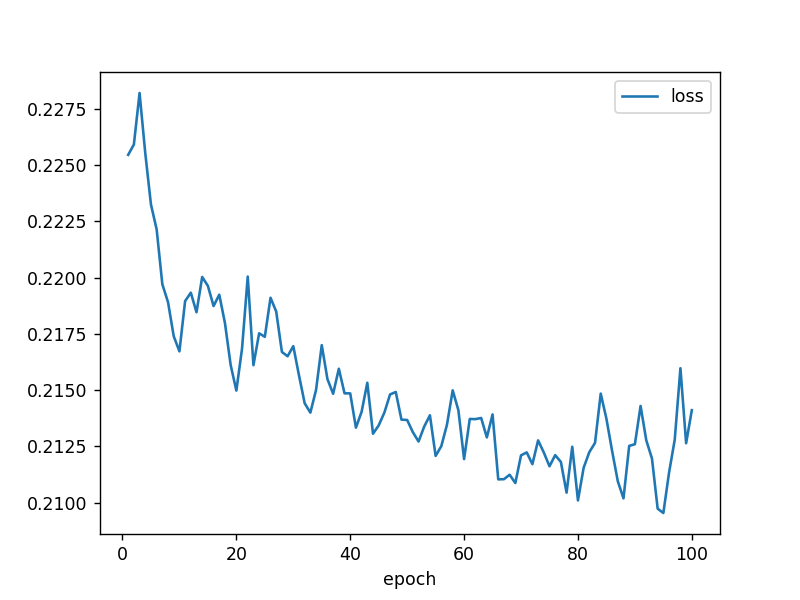

<Axes: xlabel='epoch'>

In [147]:
trainer.metrics.groupby('epoch').mean().reset_index().plot(y='loss', x='epoch')

<IPython.core.display.Javascript object>


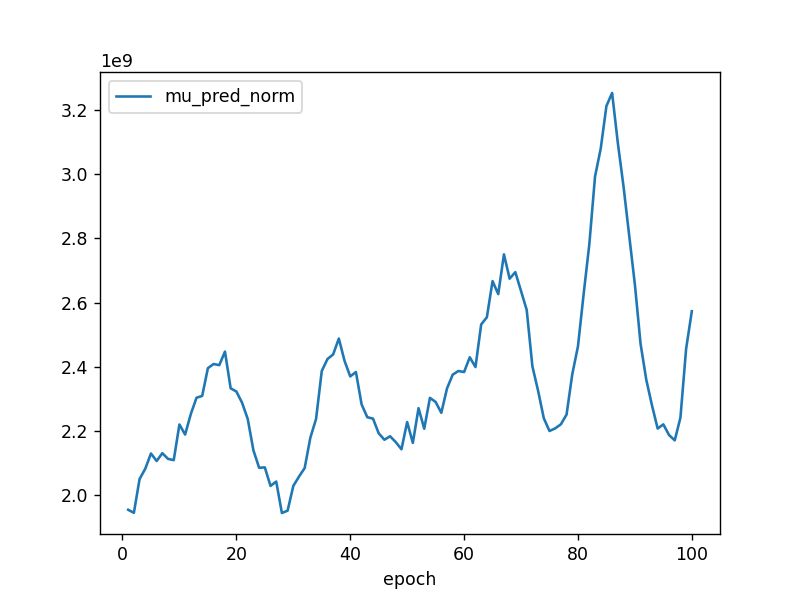

<Axes: xlabel='epoch'>

In [148]:
trainer.metrics.groupby('epoch').mean().reset_index().plot(y='mu_pred_norm', x='epoch')

<IPython.core.display.Javascript object>


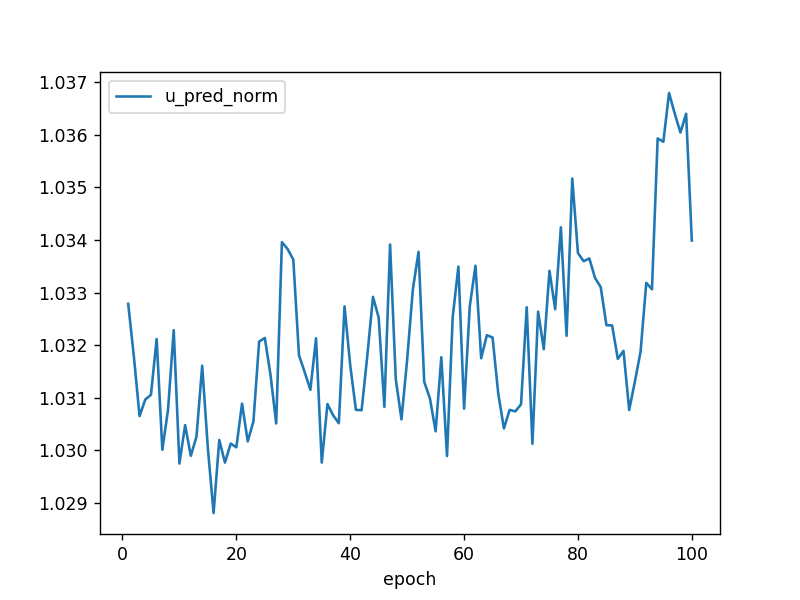

<Axes: xlabel='epoch'>

In [149]:
trainer.metrics.groupby('epoch').mean().reset_index().plot(y='u_pred_norm', x='epoch')

<IPython.core.display.Javascript object>


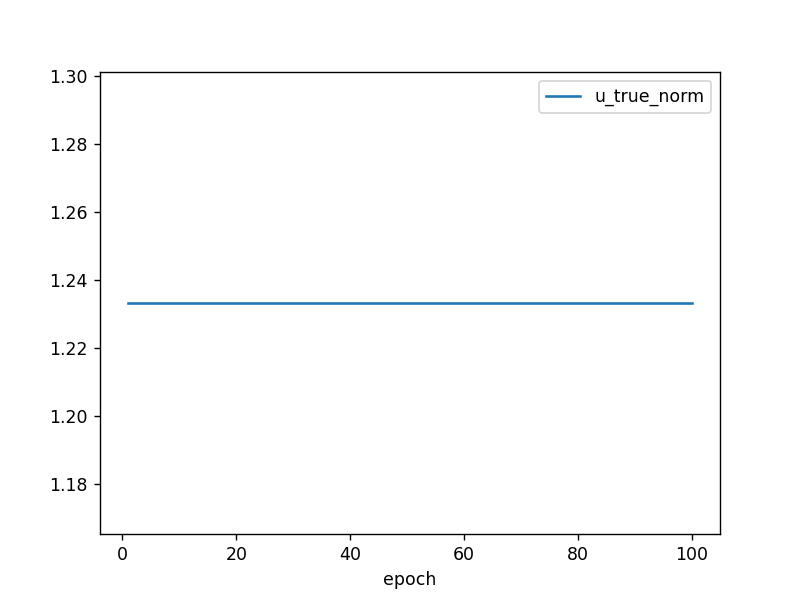

<Axes: xlabel='epoch'>

In [150]:
trainer.metrics.groupby('epoch').mean().reset_index().plot(y='u_true_norm', x='epoch')

In [151]:
mu_pred_image, u_pred_image = trainer.test(dataset[0])
mu_pred_image

Tensor(shape=(1, 256, 256, 94), μ=861.9308, σ=10663.4085, #nan=0, dtype=torch.float64, device=cpu)

In [152]:
u_pred_image

Tensor(shape=(3, 256, 256, 94), μ=-0.0028, σ=0.3701, #nan=0, dtype=torch.float64, device=cpu)

<IPython.core.display.Javascript object>


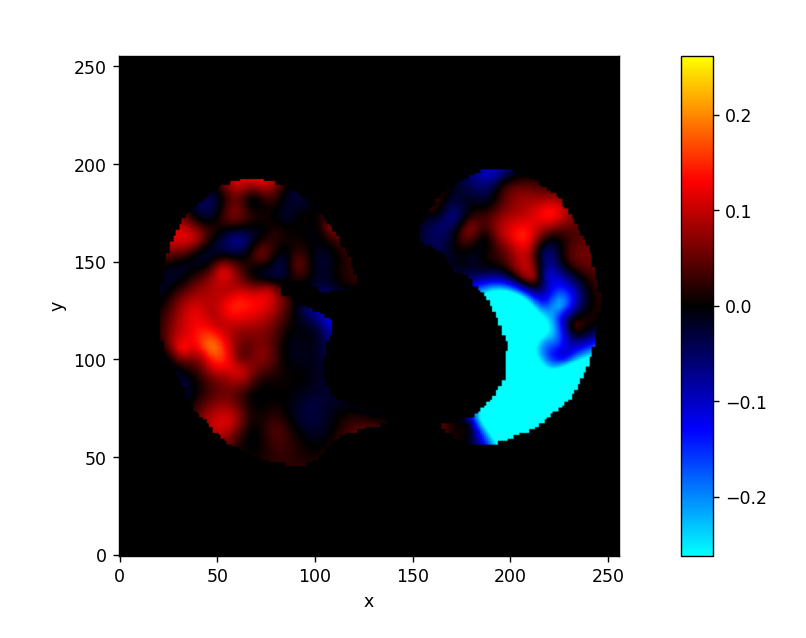

interactive(children=(SelectionSlider(description='c', options=((0, 0), (1, 1), (2, 2)), value=0), SelectionSl…

In [159]:
project.visual.view(as_xarray(u_true_image * mask, dims=['c', 'x', 'y', 'z'], name='u'))

In [168]:
anat_image, u_true_image, mask, mesh, resolution, example_name = dataset[0]
shape = tuple(anat_image.shape[1:])
shape, resolution

((256, 256, 94), (0.97, 0.97, 2.5))

<IPython.core.display.Javascript object>


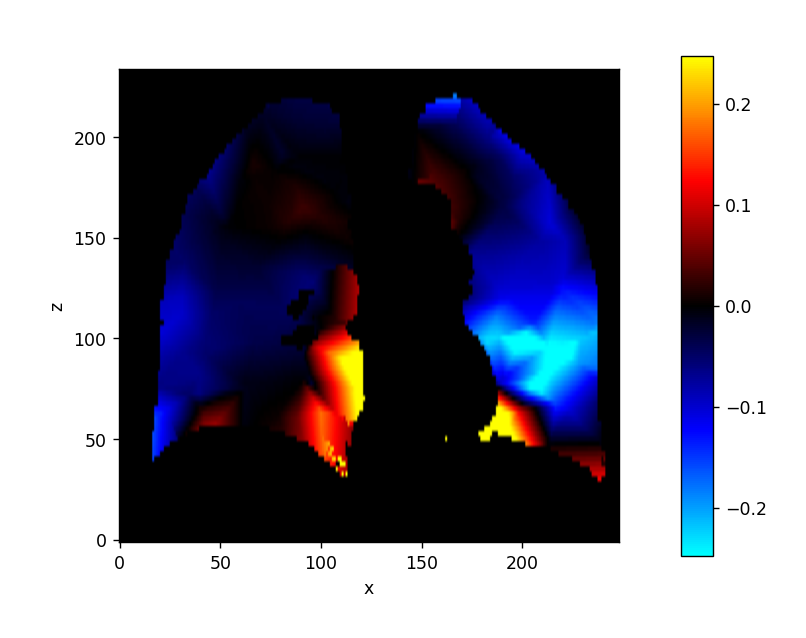

interactive(children=(SelectionSlider(description='c', options=(('x', 0), ('y', 1), ('z', 2)), value=0), Selec…

In [170]:
project.visual.view(as_xarray(
    u_pred_image * mask.cpu(),
    dims=['c', 'x', 'y', 'z'],
    coords={
        'c': ['x', 'y', 'z'],
        'x': np.arange(shape[0]) * resolution[0],
        'y': np.arange(shape[1]) * resolution[1],
        'z': np.arange(shape[2]) * resolution[2],
    },
    name='u'
), y='z')

In [162]:
anat_image = dataset[0][0]
mu_pred_image = trainer.model.forward(anat_image.unsqueeze(0))[0]
mu_pred_image = torch.nn.functional.softplus(mu_pred_image) * 1000

<IPython.core.display.Javascript object>


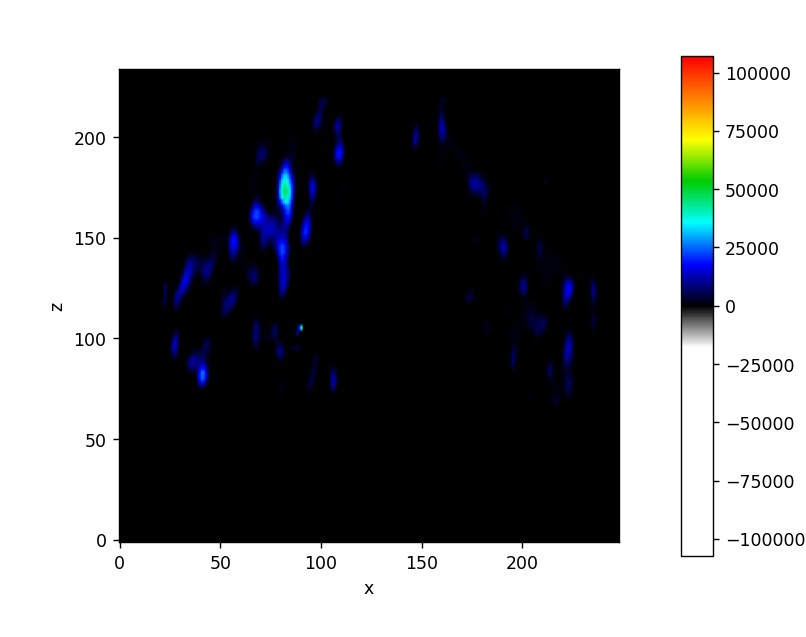

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

In [172]:
project.visual.view(as_xarray(
    mu_pred_image * mask,
    dims=['c', 'x', 'y', 'z'],
    coords={
        'c': [0],
        'x': np.arange(shape[0]) * resolution[0],
        'y': np.arange(shape[1]) * resolution[1],
        'z': np.arange(shape[2]) * resolution[2],
    },
    name='mu'
), y='z')

In [173]:
mu_pred_image = mu_pred_image.detach()
mu_pred_image.requires_grad = True
mu_pred_image

Tensor(shape=(1, 256, 256, 94), μ=3890.9187, σ=11117.4775, #nan=0, dtype=torch.float32, device=cuda:0)

In [174]:
pde = LinearElasticPDE(mesh)

mu_pred_dofs = project.interpolate.image_to_dofs(mu_pred_image, resolution, pde.S)
mu_pred_dofs

Tensor(shape=(346,), μ=1098.3645, σ=3936.0243, #nan=0, dtype=torch.float64, device=cuda:0)

In [175]:
L = mu_pred_dofs.sum()
L

Tensor(shape=(), μ=380034.1320, σ=nan, #nan=0, dtype=torch.float64, device=cuda:0)

In [176]:
L.backward()

<IPython.core.display.Javascript object>


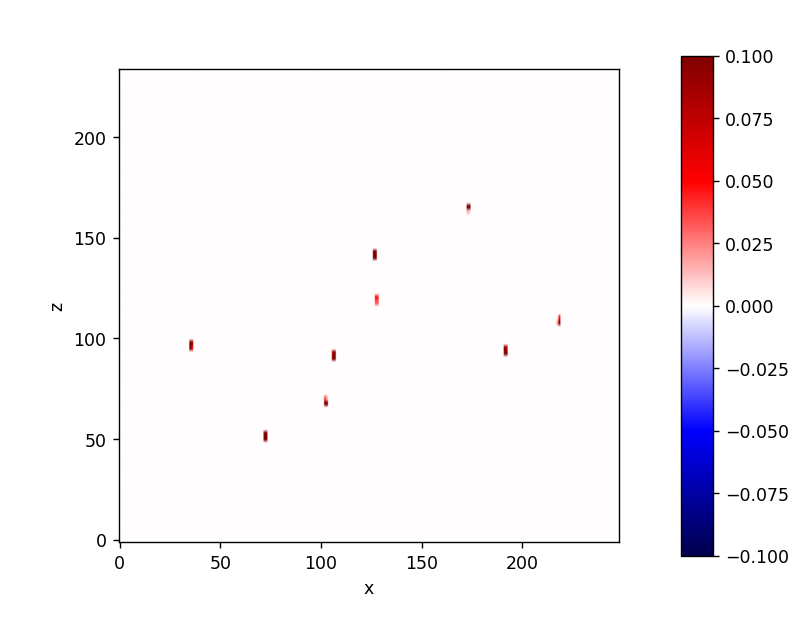

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

In [179]:
project.visual.view(as_xarray(
    mu_pred_image.grad,
    dims=['c', 'x', 'y', 'z'],
    coords={
        'c': [0],
        'x': np.arange(shape[0]) * resolution[0],
        'y': np.arange(shape[1]) * resolution[1],
        'z': np.arange(shape[2]) * resolution[2],
    }
), y='z', cmap='seismic')